<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project7_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://dataanalyticsedge.com/wp-content/uploads/2019/11/stocks_BSE_Nifty_Sensex__markets_bse_nse_nifty-1_1280-770x433.jpg)

Predicting how the stock market will perform is one of the most difficult things to do. There are so many factors involved in the prediction – physical factors vs. physhological, rational and irrational behaviour, etc. All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

Can we use machine learning as a game changer in this domain? In this project, historical stock prices data of Apple and Amazon company, from 2006 to 2017, were used for experimentation, using machine learning techniques, such as RNN, LSTM, and GRU.


#Setup

In [0]:
# Common Import
import sklearn
import pandas as pd
import numpy as np

# Algorithm libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras import optimizers
from keras import losses

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from datetime import date

import math

# Visaulization libraries
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

#Load Data

In [0]:
apple_stock = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/AAPL_2006-01-01_to_2018-01-01.csv',index_col='Date', parse_dates=["Date"]) 

In [0]:
apple_stock

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL


Check if there're missing data

In [0]:
apple_stock.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

No missing values. GREAT !!!

The assignment promts to use 12 motnths record; therefore, let's use data in 2016 as a training set and 2017 as a test set, by using only price 'High' column

In [0]:
train_2016 = apple_stock['2016':'2016'].iloc[:,1:2].values
test_2017 = apple_stock['2017':].iloc[:,1:2].values

In [0]:
train_2016.shape, test_2017.shape

((252, 1), (251, 1))

###Visualization of "High" attribute

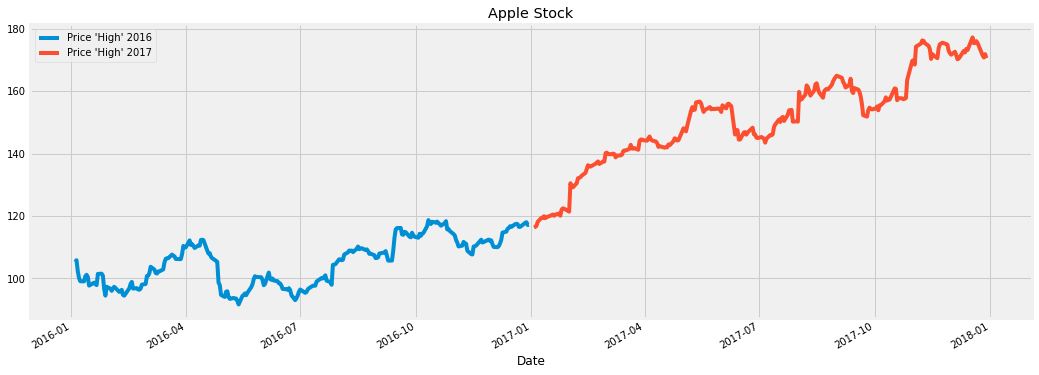

In [0]:
apple_stock["High"]['2016':'2016'].plot(figsize=(16,6), legend=True)
apple_stock["High"]["2017":].plot(figsize=(16,6), legend=True)
plt.legend(["Price 'High' 2016", "Price 'High' 2017"])
plt.title("Apple Stock")
plt.show()

###Scale the training set

In [0]:
sc = MinMaxScaler(feature_range=(0,1))
sc.fit(train_2016)
train_sc = sc.transform(train_2016)

###Create traininig set for LSTM with X=10 days for each output y

In [0]:
X_train = []
y_train = []

for i in range(10,train_2016.shape[0]):
    X_train.append(train_sc[i-10:i, 0])
    y_train.append(train_sc[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train[0] # 10 days data

array([0.50703183, 0.52479645, 0.39600296, 0.31310141, 0.27535159,
       0.27350111, 0.33382679, 0.35233161, 0.32605477, 0.22353812])

In [0]:
y_train[0]

0.2583271650629162

In [0]:
X_train.shape, y_train.shape

((242, 10), (242,))

In [0]:
# Reshape X_train for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
X_train.shape

(242, 10, 1)

#LSTM's model

In [0]:
regressor = Sequential()

# add first layer with dropout
regressor.add(LSTM(units=10, return_sequences=True,activation='relu', input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer
regressor.add(LSTM(units=100,activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer
regressor.add(LSTM(units=50,activation='relu'))
regressor.add(Dropout(0.2))

# add fourth layer
#regressor.add(LSTM(units=50))
#regressor.add(Dropout(0.2))

# the output layer
regressor.add(Dense(units=1))

###Compile LSTM RNN network

In [0]:
regressor.compile(optimizer=optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

In [0]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           44400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

###Fit the model with training set

In [0]:
regressor.fit(X_train, y_train, epochs=400, batch_size=50, validation_split=0.30)

Train on 169 samples, validate on 73 samples
Epoch 1/400
169/169 [==============================] - 1s 8ms/step - loss: 0.1758 - val_loss: 0.5440
Epoch 2/400
169/169 [==============================] - 0s 684us/step - loss: 0.0966 - val_loss: 0.2839
Epoch 3/400
169/169 [==============================] - 0s 669us/step - loss: 0.0469 - val_loss: 0.1277
Epoch 4/400
169/169 [==============================] - 0s 613us/step - loss: 0.0656 - val_loss: 0.0933
Epoch 5/400
169/169 [==============================] - 0s 687us/step - loss: 0.0681 - val_loss: 0.1336
Epoch 6/400
169/169 [==============================] - 0s 665us/step - loss: 0.0527 - val_loss: 0.2116
Epoch 7/400
169/169 [==============================] - 0s 610us/step - loss: 0.0469 - val_loss: 0.2613
Epoch 8/400
169/169 [==============================] - 0s 663us/step - loss: 0.0491 - val_loss: 0.2708
Epoch 9/400
169/169 [==============================] - 0s 633us/step - loss: 0.0495 - val_loss: 0.2471
Epoch 10/400
169/169 [========

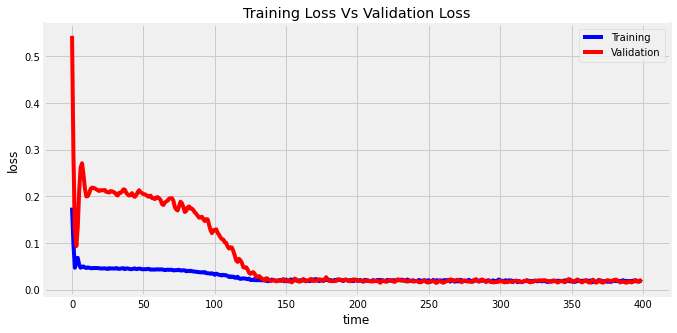

In [0]:
plt.figure(figsize=(10,5))
plt.plot(regressor.history.history['loss'], label='Training', color='blue')
plt.plot(regressor.history.history['val_loss'], label='Validation', color='red')
plt.legend()
plt.title("Training Loss Vs Validation Loss")
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

###Preprocessing test set

In [0]:
data_concat = pd.concat((apple_stock['High']['2016':'2016'], apple_stock['High']['2017':]), axis=0)
print(data_concat.shape)

inputs = data_concat[len(data_concat)-len(test_2017)-10 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)

(503,)
(261,)
(261, 1)


In [0]:
X_test = []
for i in range(10,inputs.shape[0]):
    X_test.append(inputs[i-10:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

###Predict stock price in 2017

In [0]:
pred_lstm = regressor.predict(X_test)
pred_lstm = sc.inverse_transform(pred_lstm)

###Plot prediction

In [0]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="Actual")
    plt.plot(predicted, color="blue", label="Predicted")
    plt.title("Apple stock price prediction")
    plt.xlabel("time")
    plt.ylabel("Apple stock price")
    plt.legend()
    plt.show()

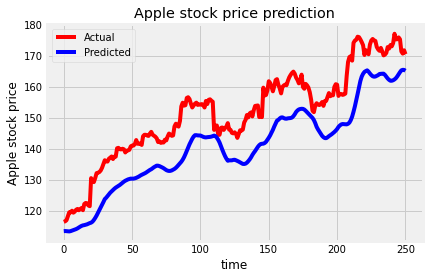

In [0]:
plot_predictions(test_2017, pred_lstm)

###RMSE of the model

In [0]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [0]:
rmse_lstm_2017 = return_rmse(test_2017, pred_lstm)
print("RMSE = {}.".format(rmse_lstm_2017))

RMSE = 11.310618916192931.


#GRU's model

In [0]:
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=10, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, input_shape=(X_train.shape[1],1), activation='relu'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
#regressorGRU.add(GRU(units=50, activation='relu'))
#regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

###Compile the model

In [0]:
regressorGRU.compile(optimizer=optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

###Fit the model with training set

In [0]:
regressorGRU.fit(X_train, y_train, epochs=400, batch_size=150, validation_split=0.30)

Train on 169 samples, validate on 73 samples
Epoch 1/400
169/169 [==============================] - 1s 7ms/step - loss: 0.1839 - val_loss: 0.6167
Epoch 2/400
169/169 [==============================] - 0s 396us/step - loss: 0.1536 - val_loss: 0.4973
Epoch 3/400
169/169 [==============================] - 0s 330us/step - loss: 0.1052 - val_loss: 0.3546
Epoch 4/400
169/169 [==============================] - 0s 386us/step - loss: 0.0655 - val_loss: 0.2284
Epoch 5/400
169/169 [==============================] - 0s 366us/step - loss: 0.0463 - val_loss: 0.1434
Epoch 6/400
169/169 [==============================] - 0s 362us/step - loss: 0.0472 - val_loss: 0.0967
Epoch 7/400
169/169 [==============================] - 0s 358us/step - loss: 0.0565 - val_loss: 0.0760
Epoch 8/400
169/169 [==============================] - 0s 350us/step - loss: 0.0657 - val_loss: 0.0752
Epoch 9/400
169/169 [==============================] - 0s 374us/step - loss: 0.0694 - val_loss: 0.0925
Epoch 10/400
169/169 [========

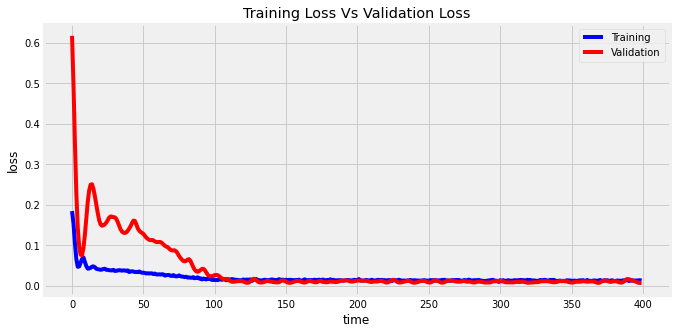

In [0]:
plt.figure(figsize=(10,5))
plt.plot(regressorGRU.history.history['loss'], label='Training', color='blue')
plt.plot(regressorGRU.history.history['val_loss'], label='Validation', color='red')
plt.legend()
plt.title("Training Loss Vs Validation Loss")
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

###Predict the stock price

In [0]:
pred_gru = regressorGRU.predict(X_test)
pred_gru = sc.inverse_transform(pred_gru)

###Plot the prediction

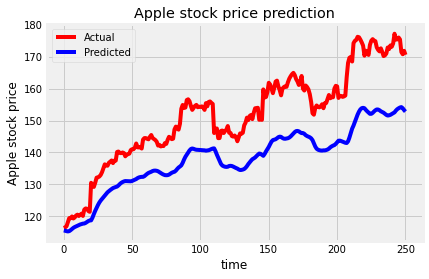

In [0]:
plot_predictions(test_2017, pred_gru)

###RMSE of the model

In [0]:
return_rmse(test_2017, pred_gru)
rmse_gru_2017 = return_rmse(test_2017, pred_gru)
print("RMSE = {}.".format(rmse_gru_2017))

RMSE = 14.322629824567592.


#Testing Models

here the model will be tested with three different period as following:
1. 2020-4-3 to 2020-5-1
2. The next five monthes after 2018-1-1
3. The next ten monthes after 2018-1-1




In [0]:
def preprossing_data_rnns(data):
  data_x = []
  data_y = []
  for i in range(10,len(data)):
    data_x.append(data[i-10:i, 0])
    data_y.append(data[i,0])
  data_x = sc.transform(data_x)
  data_x, data_y = np.array(data_x), np.array(data_y)
  data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))
  return data_x, data_y

def predic_using_LSTM(data_x):
  pred_lstm_new = regressor.predict(data_x)
  pred_lstm_new = sc.inverse_transform(pred_lstm_new)
  return pred_lstm_new

def predic_using_gru(data_x):
  pred_gru_new = regressorGRU.predict(data_x)
  pred_gru_new = sc.inverse_transform(pred_gru_new)
  return pred_gru_new


##Get the pariod from 2020-4-3 to 2020-5-1 months after 2018-1-1

In [0]:
apple_data_4_5 = pd.read_csv('https://raw.githubusercontent.com/ahshawaf/AML/project7/APPL_2020-03-04_to_2020-01-05.csv',index_col='Date', parse_dates=["Date"]) 

In [0]:
apple_data_4_5.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-05-01,289.07,60154180.0,286.25,299.00,285.85
2020-04-30,293.80,45765970.0,289.96,294.53,288.35
2020-04-29,287.73,34320200.0,284.73,289.67,283.89
2020-04-28,278.58,28001190.0,285.08,285.83,278.20
2020-04-27,283.17,29271890.0,281.80,284.54,279.95


In [0]:
apple_data_4_5_high = apple_data_4_5.iloc[:,3].values
apple_data_4_5_high

array([299.  , 294.53, 289.67, 285.83, 284.54, 283.01, 281.75, 277.9 ,
       277.25, 281.68, 286.95, 288.2 , 286.33, 288.25, 273.7 , 270.07,
       267.37, 271.7 , 263.11, 245.7 ])

In [0]:
apple_data_4_5_high.shape

(20,)

In [0]:
apple_data_4_5_high=apple_data_4_5_high.reshape(-1,1)
apple_data_4_5_high.shape

(20, 1)

In [0]:
apple_x_4_5,apple_y_4_5 = preprossing_data_rnns(np.array(apple_data_4_5_high))

predict using LSTM

In [0]:
pred_lstm_apple_4_5 = predic_using_LSTM(apple_x_4_5)

In [0]:
pred_lstm_apple_4_5

array([[313.4467 ],
       [310.73846],
       [309.07904],
       [308.56805],
       [308.8545 ],
       [308.85825],
       [308.70685],
       [307.70157],
       [306.73465],
       [305.1997 ]], dtype=float32)

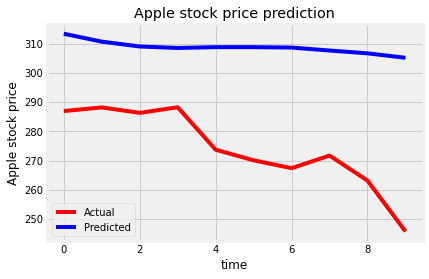

In [0]:
plot_predictions(apple_y_4_5,pred_lstm_apple_4_5)

In [0]:
rmse_lstm_4_5_2020=return_rmse(apple_y_4_5,pred_lstm_apple_4_5)
print('RMSE = {}'.format(rmse_lstm_4_5_2020))

RMSE = 36.508818650925456


predict using GRU

In [0]:
pred_gru_apple_4_5 = predic_using_gru(apple_x_4_5)

In [0]:
pred_gru_apple_4_5

array([[221.30988],
       [221.86232],
       [222.81146],
       [223.47737],
       [224.1551 ],
       [222.92734],
       [220.88783],
       [218.65053],
       [217.30707],
       [215.50479]], dtype=float32)

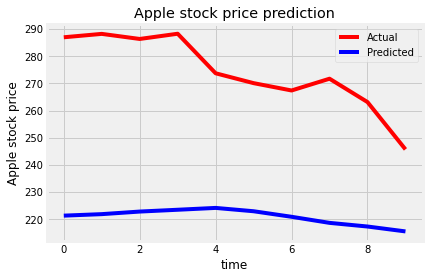

In [0]:
plot_predictions(apple_y_4_5,pred_gru_apple_4_5)

In [0]:
rmse_gru_4_5_2020=return_rmse(apple_y_4_5,pred_gru_apple_4_5)
print('RMSE = {}'.format(rmse_gru_4_5_2020))

RMSE = 54.406834647798654


##Get the next five months after 2018-1-1

In [0]:

data_2 = pd.read_csv('https://raw.githubusercontent.com/ahshawaf/AML/project7/AAPL_2015-04-05_to_2020-01-05.csv',index_col='Date', parse_dates=["Date"]) 

In [0]:
data_2.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-05-01,289.07,60154180.0,286.25,299.00,285.85
2020-04-30,293.80,45765970.0,289.96,294.53,288.35
2020-04-29,287.73,34320200.0,284.73,289.67,283.89
2020-04-28,278.58,28001190.0,285.08,285.83,278.20
2020-04-27,283.17,29271890.0,281.80,284.54,279.95


In [0]:
#this is a custom function get the a specific data with a specific period. The 'from date' is included but the 'to date' is not
def get_period_of_data(data,from_year,from_month,from_day,to_year,to_month,to_day):
  from_date = pd.Timestamp(date(from_year,from_month,from_day))
  to_date = pd.Timestamp(date(to_year,to_month,to_day))
  result = data_2[(data.index >= from_date) &  (data.index < to_date)]
  return result

##Predict for the next five months

In [0]:
apple_1_5=get_period_of_data(data_2,2018,1,1,2018,6,1)
apple_1_5

,Close/Last,Volume,Open,High,Low
Date,,,,,
2018-05-31,186.87,27468700.0,187.22,188.23,186.14
2018-05-30,187.50,18503410.0,187.72,188.00,186.78
2018-05-29,187.90,22409110.0,187.60,188.75,186.87
2018-05-25,188.58,17186760.0,188.23,189.65,187.65
2018-05-24,188.15,23129400.0,188.77,188.84,186.21
...,...,...,...,...,...
2018-01-08,174.35,20523870.0,174.35,175.61,173.93
2018-01-05,175.00,23589930.0,173.44,175.37,173.05
2018-01-04,173.03,22342650.0,172.54,173.47,172.08


In [0]:
apple_1_5_high = apple_1_5.iloc[:,3].values

In [0]:
apple_1_5_high

array([188.23, 188.  , 188.75, 189.65, 188.84, 188.5 , 188.88, 189.27,
       187.81, 188.91, 188.46, 187.07, 189.53, 190.06, 190.37, 187.4 ,
       186.22, 187.67, 184.25, 177.5 , 177.75, 169.2 , 167.26, 164.33,
       165.73, 165.42, 166.33, 166.92, 171.22, 175.39, 178.82, 178.94,
       176.19, 175.84, 175.  , 173.92, 174.  , 173.09, 172.48, 174.23,
       172.01, 168.75, 168.94, 171.75, 170.02, 175.15, 173.1 , 169.92,
       172.68, 175.09, 176.8 , 177.47, 179.12, 180.24, 180.52, 183.5 ,
       182.39, 180.  , 177.12, 175.85, 178.25, 177.74, 176.3 , 179.78,
       180.62, 180.48, 179.39, 175.65, 173.95, 174.12, 174.26, 174.82,
       173.09, 167.54, 164.75, 163.89, 157.89, 161.  , 163.4 , 163.72,
       163.88, 166.8 , 168.62, 168.44, 167.37, 170.16, 172.  , 174.95,
       177.3 , 179.44, 177.78, 179.58, 180.1 , 179.25, 179.39, 177.36,
       175.49, 174.3 , 175.06, 175.61, 175.37, 173.47, 174.55, 172.3 ])

In [0]:
apple_1_5_high = apple_1_5_high.reshape(-1,1)
apple_1_5_high.shape

(104, 1)

In [0]:
apple_1_5_x,apple_1_5_y = preprossing_data_rnns(np.array(apple_1_5_high))

predict using LSTM

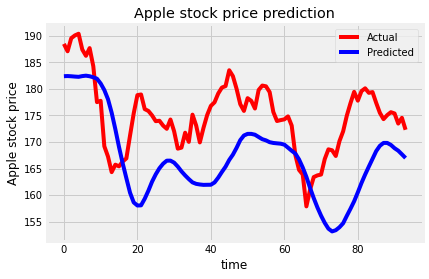

In [0]:
apple_1_5_pred= predic_using_LSTM(apple_1_5_x)
plot_predictions(apple_1_5_y,apple_1_5_pred)

In [0]:
rmse_lstm_1_5_2018=return_rmse(apple_1_5_y,apple_1_5_pred)
print("RMSE = {}".format(rmse_lstm_1_5_2018))

RMSE = 10.605944031281997


predict using gru

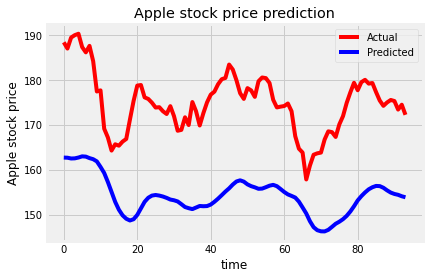

In [0]:
apple_1_5_pred= predic_using_gru(apple_1_5_x)
plot_predictions(apple_1_5_y,apple_1_5_pred)

In [0]:
rmse_gru_1_5_2018=return_rmse(apple_1_5_y,apple_1_5_pred)
print("RMSE = {}".format(rmse_gru_1_5_2018))

RMSE = 21.134372493466728


##Get the next ten months after 2018-1-1

In [0]:
apple_1_11=get_period_of_data(data_2,2018,1,1,2018,11,1)
apple_1_11

,Close/Last,Volume,Open,High,Low
Date,,,,,
2018-10-31,218.86,38016810.0,216.88,220.45,216.62
2018-10-30,213.30,36487930.0,211.15,215.18,209.27
2018-10-29,212.24,45713690.0,219.19,219.69,206.09
2018-10-26,216.30,47191700.0,215.90,220.19,212.67
2018-10-25,219.80,29027340.0,217.71,221.38,216.75
...,...,...,...,...,...
2018-01-08,174.35,20523870.0,174.35,175.61,173.93
2018-01-05,175.00,23589930.0,173.44,175.37,173.05
2018-01-04,173.03,22342650.0,172.54,173.47,172.08


In [0]:
apple_1_11_high = apple_1_11.iloc[:,3].values
apple_1_11_high.shape

(211,)

In [0]:
apple_1_11_high = apple_1_11_high.reshape(-1,1)
apple_1_11_high.shape

(211, 1)

In [0]:
apple_1_11_x,apple_1_11_y = preprossing_data_rnns(np.array(apple_1_11_high))

predict using LSTM

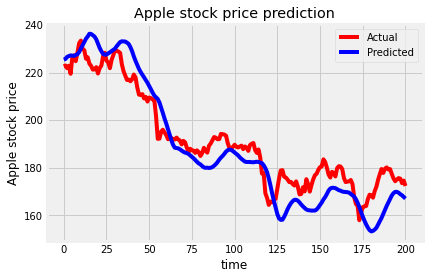

In [0]:
apple_1_11_pred= predic_using_LSTM(apple_1_11_x)
plot_predictions(apple_1_11_y,apple_1_11_pred)

In [0]:
rmse_lstm_1_11_2018=return_rmse(apple_1_11_y,apple_1_11_pred)
print("RMSE = {}".format(rmse_lstm_1_11_2018))

RMSE = 9.07249622749244


predict using GRU

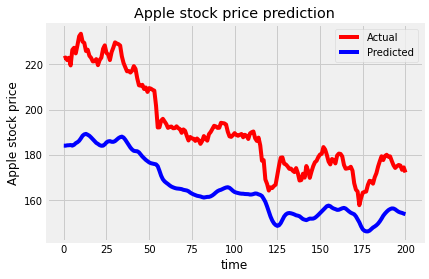

In [0]:
apple_1_11_pred= predic_using_gru(apple_1_11_x)
plot_predictions(apple_1_11_y,apple_1_11_pred)

In [0]:
rmse_gru_1_11_2018=return_rmse(apple_1_11_y,apple_1_11_pred)
print("RMSE = {}".format(rmse_gru_1_11_2018))

RMSE = 27.486767638487763


#Comparing RMSE results

In this section the RMSE results will be compared with all periods for LSTM and GRU
1. data of 2017
2. 2020-4-3 to 2020-5-1
3. The next five monthes after 2018-1-1
4. The next ten monthes after 2018-1-1

In [0]:
#This list to be used for adding the text with the value for each corresponding bar
rmse_values = [rmse_lstm_2017,rmse_gru_2017,rmse_lstm_4_5_2020,rmse_gru_4_5_2020,rmse_lstm_1_5_2018,rmse_gru_1_5_2018,rmse_lstm_1_11_2018,rmse_gru_1_11_2018]
rmse_values

[11.310618916192931,
 14.322629824567592,
 36.508818650925456,
 54.406834647798654,
 10.605944031281997,
 21.134372493466728,
 9.07249622749244,
 27.486767638487763]

Now, the chart will be drawn

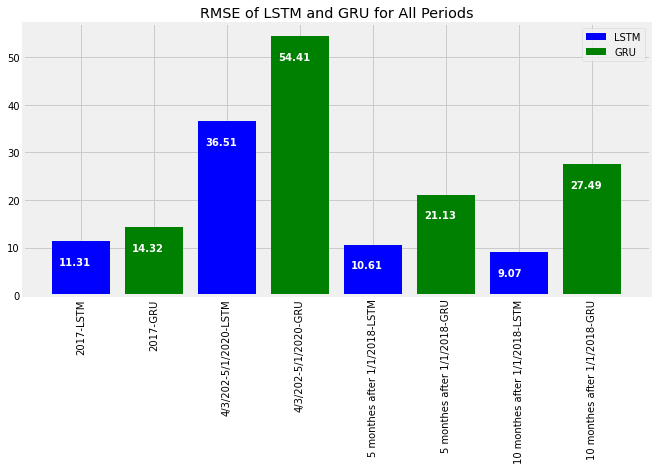

In [0]:
plt.figure(figsize=(10,5))
plt.bar('2017-LSTM', rmse_lstm_2017,color='blue')
plt.bar('2017-GRU', rmse_gru_2017,color='green' )

plt.bar('4/3/202-5/1/2020-LSTM', rmse_lstm_4_5_2020,color='blue')
plt.bar('4/3/202-5/1/2020-GRU', rmse_gru_4_5_2020,color='green')

plt.bar('5 monthes after 1/1/2018-LSTM', rmse_lstm_1_5_2018,color='blue')
plt.bar('5 monthes after 1/1/2018-GRU', rmse_gru_1_5_2018,color='green')

plt.bar('10 monthes after 1/1/2018-LSTM', rmse_lstm_1_11_2018,color='blue')
plt.bar('10 monthes after 1/1/2018-GRU', rmse_gru_1_11_2018,color='green')

plt.xticks(rotation=90)
plt.title("RMSE of LSTM and GRU for All Periods")
plt.legend(['LSTM','GRU'])

x_postion = -0.3
for float in rmse_values:
  plt.text(x_postion,float-5,'{:.2f}'.format(float), color='white', weight='bold')
  x_postion = x_postion + 1

This bar chart indicated that LSTM model performed better than GRU model, such that LSTM produced RMSE value less than GRU for all periods. However, the RMSE value for both LSTM and GUR, from 2020-4-3 to 2020-5-1, is the highest because there is a 4 years gap between the training data and validation data. In other words, 2016 data was used for training and 2020 data was used for validate the prediction.  

#Conclusion

Each model was trained with 2016 data and tested with different future periods to see how the prediction differentiate.  
Here's the summary of tested periods:

*   2017: entire year
*   Five months after 2018-1-1
*   Ten monthes after 2018-1-1
*   2020: 2020-4-3 to 2020-5-1

Overall, LSTM model is the winner for this experimentation for all period prediction.

#Refrences

- https://www.kaggle.com/dpamgautam/stock-price-prediction-lstm-gru-rnn/notebook

- http://queirozf.com/entries/pandas-dataframe-examples-manipulating-date-and-time

- https://www.nasdaq.com/market-activity/stocks/aapl/historical


